In [1]:
import networkx as nx

import numpy as np
import pandas as pd

import seaborn as sn
import matplotlib.pyplot as plt
import matplotlib as mpl

import random
import math

from sklearn.ensemble import RandomForestClassifier
from sklearn import metrics

In [2]:
# hyperparameters

seed = random.randint(1, 1000)         # random seed

# Experiments on real data
Here we use 'Garfield citations network' from 'Stacking models for nearly optimal link prediction in complex networks' paper by Amir Ghasemian et al:
 - https://github.com/Aghasemian/OptimalLinkPrediction
 - https://www.pnas.org/content/117/38/23393 

## Step 1
### Graph and features imoprting, train-test splitting

We import the desired network and its features from `OLP` class and split the data into train and test sets.

In [3]:
from lib.generators.OLP import OLP


generator = OLP(
    network_name='58b0173aa411221d0e7c680c', 
    seed=seed
)

feature_names = generator.feature_names

Loading file...
Network info:

title: Garfield's citation networks (2001)
description: Several networks of citations among scientific publications, extracted from the Web of Science database using the HistCite software, circa 2001 . Each network places a particular paper as a center. Edge direction (i,j) indicates that paper i cites paper j.
networkDomain: Informational
subDomain: Citation
citation: E. Garfield, "From Computational Linguistics to Algorithmic Historiography." Symp. Honor of Casimir Borkowski at U. Pittsburgh School of Information Sciences (2001)
sourceUrl: http://garfield.library.upenn.edu/papers/pittsburgh92001.pdf

File loaded!
Calculating features...
Features calculated!
Train/test splitting...
Done splitting the data!


In [4]:
link_prediction_train, link_prediction_test, classifier_test = generator.TRAIN1_DF, generator.TEST1_DF, generator.TEST2_DF

In [5]:
link_prediction_train.head()

,node1,node2,goal,com_ne,short_path,LHN,page_rank_pers_edges,pref_attach,jacc_coeff,adam_adar,res_alloc_ind,svd_edges,svd_edges_dot,svd_edges_mean
0,253,590,0,0.0,1.000000,0.0,0.000000,0.000000,0.0,0.0,0.0,-9.449274e-18,1.314639e-15,0.000000e+00
1,218,354,0,0.0,0.000143,0.0,0.000075,0.000300,0.0,0.0,0.0,9.856984e-17,1.360747e-15,1.441772e-15
2,9,613,0,0.0,0.000143,0.0,0.000472,0.000599,0.0,0.0,0.0,2.112026e-16,1.402858e-15,4.658952e-16
3,575,834,0,0.0,0.000429,0.0,0.000225,0.001199,0.0,0.0,0.0,5.898060e-17,1.299152e-15,-1.343552e-16
4,109,253,0,0.0,1.000000,0.0,0.000001,0.000000,0.0,0.0,0.0,2.050804e-17,1.318086e-15,5.166776e-17


## Step 2
### Link prediction model

In [6]:
model = RandomForestClassifier(n_estimators=100, max_depth=3, random_state=seed)
model.fit(link_prediction_train[feature_names], link_prediction_train['goal'])

prob = model.predict_proba(link_prediction_test[feature_names])[:, 1]
prob = pd.Series(prob, name='prob')

link_proba = link_prediction_train.join(prob)
link_proba.head(5)

,node1,node2,goal,com_ne,short_path,LHN,page_rank_pers_edges,pref_attach,jacc_coeff,adam_adar,res_alloc_ind,svd_edges,svd_edges_dot,svd_edges_mean,prob
0,253,590,0,0.0,1.000000,0.0,0.000000,0.000000,0.0,0.0,0.0,-9.449274e-18,1.314639e-15,0.000000e+00,0.218349
1,218,354,0,0.0,0.000143,0.0,0.000075,0.000300,0.0,0.0,0.0,9.856984e-17,1.360747e-15,1.441772e-15,0.218349
2,9,613,0,0.0,0.000143,0.0,0.000472,0.000599,0.0,0.0,0.0,2.112026e-16,1.402858e-15,4.658952e-16,0.227827
3,575,834,0,0.0,0.000429,0.0,0.000225,0.001199,0.0,0.0,0.0,5.898060e-17,1.299152e-15,-1.343552e-16,0.178533
4,109,253,0,0.0,1.000000,0.0,0.000001,0.000000,0.0,0.0,0.0,2.050804e-17,1.318086e-15,5.166776e-17,0.178533


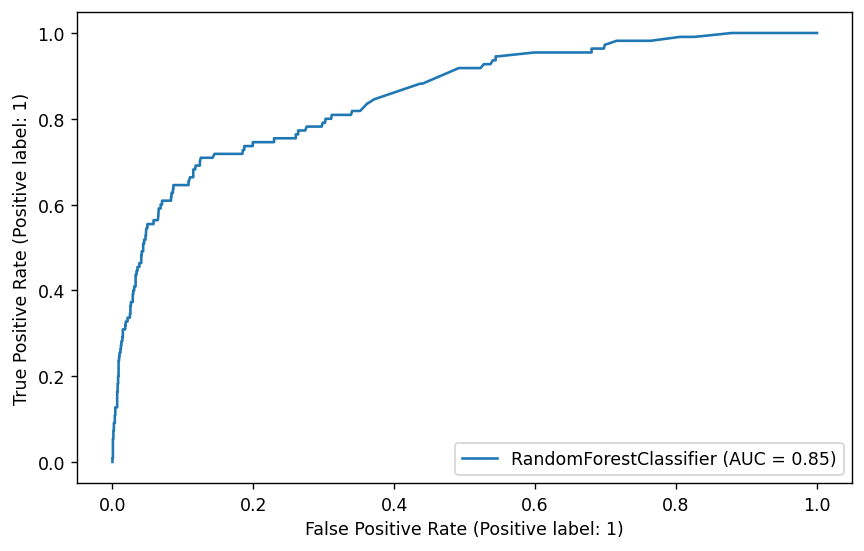

In [7]:
# ROC-AUC for the link prediction model
mpl.rcParams['figure.figsize'] = [8, 5]
mpl.rcParams['figure.dpi'] = 125

metrics.plot_roc_curve(model, link_prediction_test[feature_names], link_prediction_test['goal'])  

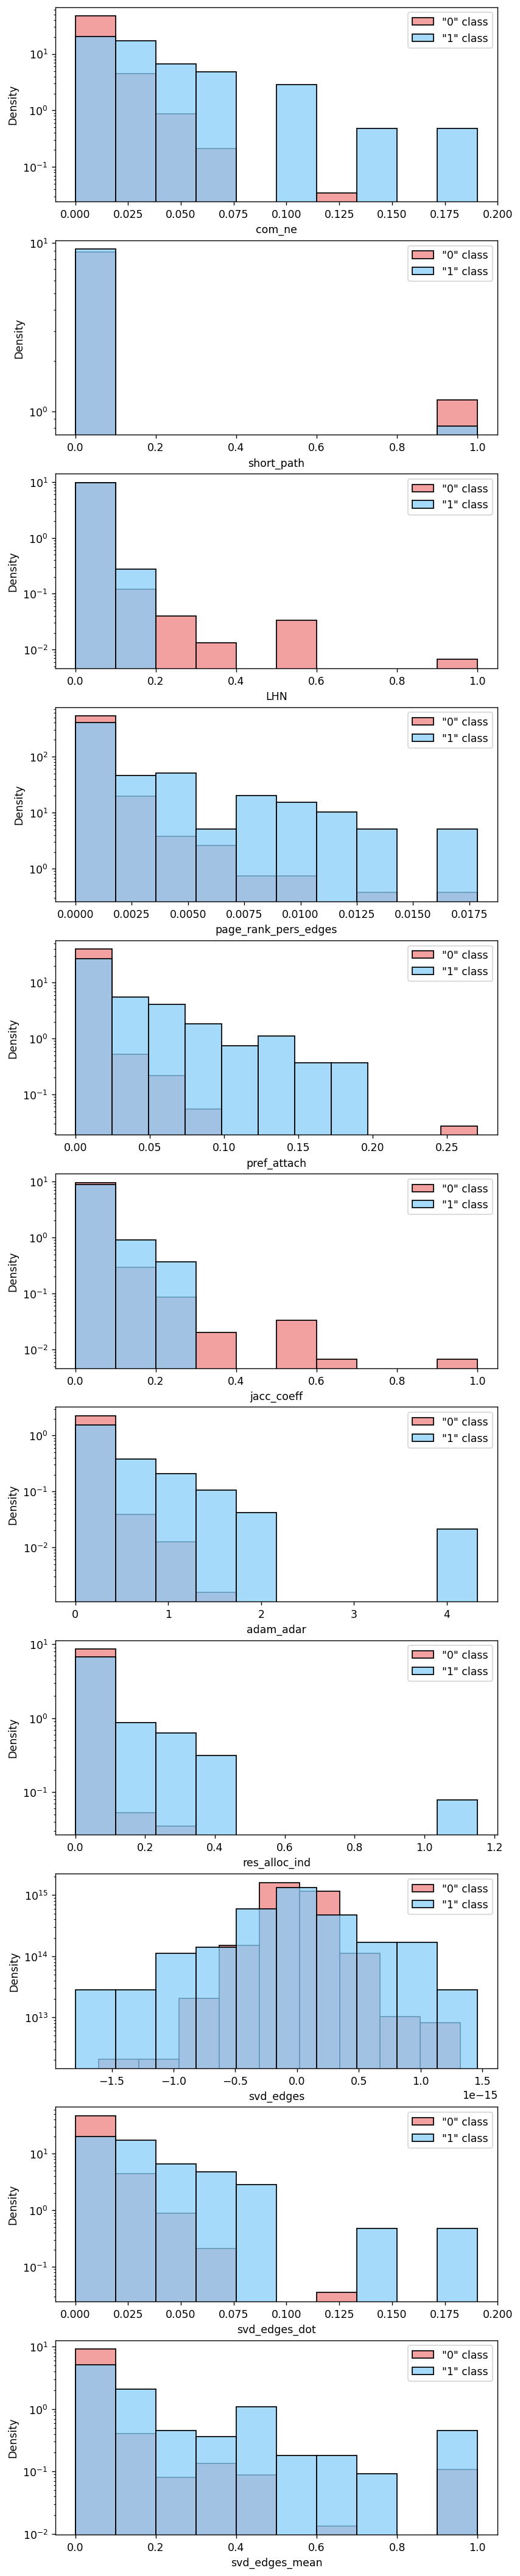

In [8]:
# distribution of features of exesting and non-existing edges

mpl.rcParams['figure.figsize'] = [7.5, 4*len(feature_names)]

fig, axs = plt.subplots(ncols=1, nrows=len(feature_names))
colors = ['lightcoral', 'lightskyblue']

for i, feature in enumerate(feature_names):
    width = (link_prediction_test[feature].max()-link_prediction_test[feature].min())/10
    for j in [0, 1]:
        data = link_prediction_test[link_prediction_test['goal'] == j]

        sn.histplot(data, x=feature, ax=axs[i], binwidth=width, color=colors[j], stat='density', label=f'"{j}" class')
        axs[i].set(xlabel=feature, ylabel='Density')
        axs[i].set_yscale("log")
        axs[i].legend()


## Step 3
Classifing error of prediction into "predictible" and "non-predictable" classes using median error

In [9]:
# absolute eroor of prediction
link_proba['abs_error'] = link_proba.apply(lambda row: math.fabs(row['goal']-row['prob']), axis=1)
link_proba.head()

,node1,node2,goal,com_ne,short_path,LHN,page_rank_pers_edges,pref_attach,jacc_coeff,adam_adar,res_alloc_ind,svd_edges,svd_edges_dot,svd_edges_mean,prob,abs_error
0,253,590,0,0.0,1.000000,0.0,0.000000,0.000000,0.0,0.0,0.0,-9.449274e-18,1.314639e-15,0.000000e+00,0.218349,0.218349
1,218,354,0,0.0,0.000143,0.0,0.000075,0.000300,0.0,0.0,0.0,9.856984e-17,1.360747e-15,1.441772e-15,0.218349,0.218349
2,9,613,0,0.0,0.000143,0.0,0.000472,0.000599,0.0,0.0,0.0,2.112026e-16,1.402858e-15,4.658952e-16,0.227827,0.227827
3,575,834,0,0.0,0.000429,0.0,0.000225,0.001199,0.0,0.0,0.0,5.898060e-17,1.299152e-15,-1.343552e-16,0.178533,0.178533
4,109,253,0,0.0,1.000000,0.0,0.000001,0.000000,0.0,0.0,0.0,2.050804e-17,1.318086e-15,5.166776e-17,0.178533,0.178533


In [10]:
train_median_error = link_proba['abs_error'].median()
train_median_error

0.48184255843032403

In [11]:
link_proba['quality_label'] = link_proba.apply(lambda row: 1 if row['abs_error'] <= train_median_error else 0, axis=1)
link_proba.head()

,node1,node2,goal,com_ne,short_path,LHN,page_rank_pers_edges,pref_attach,jacc_coeff,adam_adar,res_alloc_ind,svd_edges,svd_edges_dot,svd_edges_mean,prob,abs_error,quality_label
0,253,590,0,0.0,1.000000,0.0,0.000000,0.000000,0.0,0.0,0.0,-9.449274e-18,1.314639e-15,0.000000e+00,0.218349,0.218349,1
1,218,354,0,0.0,0.000143,0.0,0.000075,0.000300,0.0,0.0,0.0,9.856984e-17,1.360747e-15,1.441772e-15,0.218349,0.218349,1
2,9,613,0,0.0,0.000143,0.0,0.000472,0.000599,0.0,0.0,0.0,2.112026e-16,1.402858e-15,4.658952e-16,0.227827,0.227827,1
3,575,834,0,0.0,0.000429,0.0,0.000225,0.001199,0.0,0.0,0.0,5.898060e-17,1.299152e-15,-1.343552e-16,0.178533,0.178533,1
4,109,253,0,0.0,1.000000,0.0,0.000001,0.000000,0.0,0.0,0.0,2.050804e-17,1.318086e-15,5.166776e-17,0.178533,0.178533,1


In [12]:
model_2 = RandomForestClassifier(n_estimators=100, max_depth=3, random_state=seed)
model_2.fit(link_proba[feature_names], link_proba['quality_label'])

RandomForestClassifier(max_depth=3, random_state=260)

In [13]:
# testing the classifier

pred = model_2.predict(classifier_test[feature_names])
pred = pd.Series(pred, name='predicted_quality_label')

proba = model.predict_proba(classifier_test[feature_names])[:,1]
proba = pd.Series(proba, name='prediction_probability')

classifier_test = classifier_test.join(proba)
classifier_test = classifier_test.join(pred)

In [14]:
classifier_test['true_abs_error'] = classifier_test.apply(lambda row: math.fabs(row['goal']-row['prediction_probability']), axis=1)
test_median_error = classifier_test['true_abs_error'].median()
test_median_error

0.2350685535016551

In [15]:
classifier_test['true_quality_label'] = classifier_test.apply(lambda row: 1 if row['true_abs_error'] <= test_median_error else 0, axis=1)
classifier_test.head(5)

,node1,node2,goal,com_ne,short_path,LHN,page_rank_pers_edges,pref_attach,jacc_coeff,adam_adar,res_alloc_ind,svd_edges,svd_edges_dot,svd_edges_mean,prediction_probability,predicted_quality_label,true_abs_error,true_quality_label
0,565,586,0,0.00000,0.000286,0.00,0.000139,0.000200,0.000,0.000000,0.000000,-5.139274e-17,1.319473e-15,-1.905892e-16,0.177308,1,0.177308,1
1,482,926,0,0.02381,0.000000,0.05,0.002091,0.001998,0.125,0.258318,0.020833,-3.239596e-16,2.380952e-02,2.500000e-01,0.627357,0,0.627357,0
2,115,126,0,0.00000,0.000143,0.00,0.000083,0.001898,0.000,0.000000,0.000000,6.165248e-16,1.359168e-15,4.286935e-16,0.224884,1,0.224884,1
3,535,881,0,0.00000,0.000143,0.00,0.000963,0.001099,0.000,0.000000,0.000000,-9.812030e-18,1.338905e-15,3.784851e-17,0.354804,1,0.354804,0
4,400,1018,0,0.00000,0.000143,0.00,0.000440,0.003197,0.000,0.000000,0.000000,-2.636780e-16,1.221181e-15,-1.919546e-16,0.252598,1,0.252598,0


In [16]:
classifier_test[['true_quality_label']].value_counts()

true_quality_label
1                     804
0                     799
dtype: int64

In [17]:
classifier_test[['predicted_quality_label']].value_counts()

predicted_quality_label
1                          1311
0                           292
dtype: int64

In [18]:
from sklearn import metrics

y_true, y_pred = classifier_test['true_quality_label'], classifier_test['predicted_quality_label']

scores_df = pd.DataFrame()
scores_df['Metric'] = pd.Series(['Sample length', 'Accuracy', 'Precision', 'Recall', 'F1 score'])

scores_df['Score'] = pd.Series([
    len(classifier_test),
    model_2.score(classifier_test[feature_names], classifier_test['true_quality_label']),
    metrics.precision_score(y_true, y_pred, average='macro'),
    metrics.recall_score(y_true, y_pred, average='micro'),
    metrics.f1_score(y_true, y_pred, average='weighted')
])

scores_df

,Metric,Score
0,Sample length,1603.000000
1,Accuracy,0.591391
2,Precision,0.651701
3,Recall,0.591391
4,F1 score,0.545424


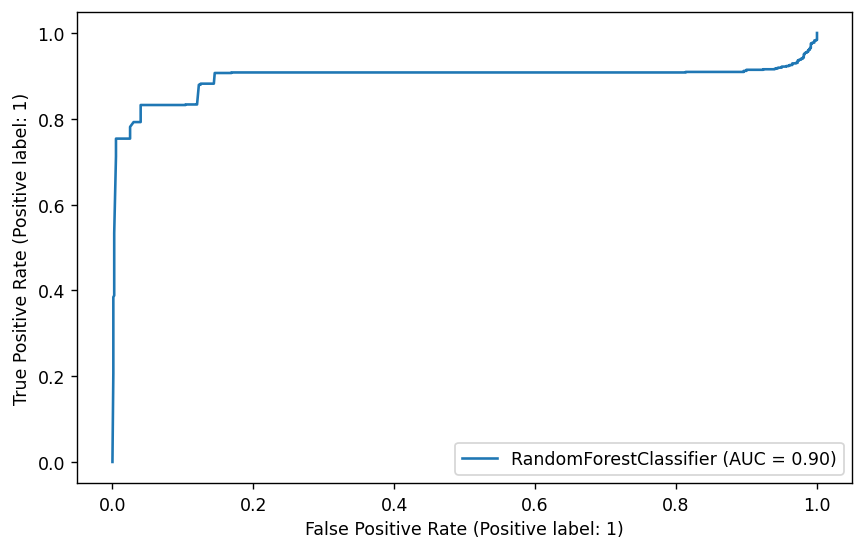

In [19]:
mpl.rcParams['figure.figsize'] = [8, 5]
mpl.rcParams['figure.dpi'] = 125

metrics.plot_roc_curve(model_2, classifier_test[feature_names], classifier_test['true_quality_label'])  

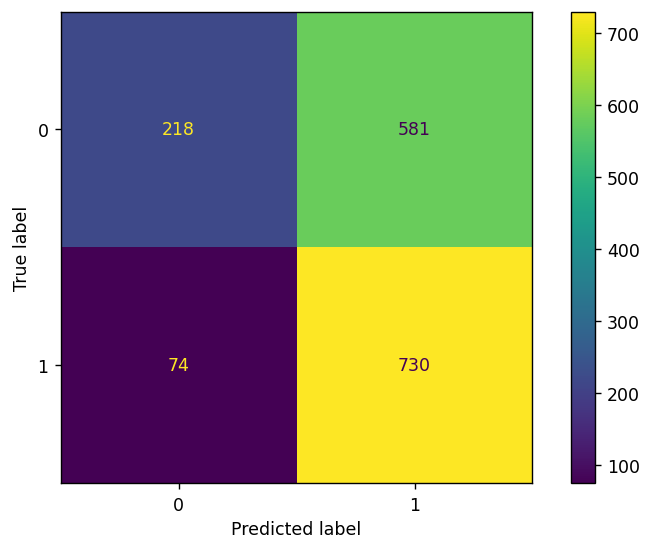

In [20]:
metrics.plot_confusion_matrix(model_2, classifier_test[feature_names], classifier_test['true_quality_label'])